# Tutorial for Primary Flare Detection

TOFFEE's main purpose is to be a flexible way to detect flares using threshold-based method. It's able to detect and distinguish overlapping flares in a lightcurve and utilizes various methods to detect a flare depending on your goals. In this notebook we'll focus on how TOFFEE detects primary flares.

The first thing to know about TOFFEE is that it's a top-down search algorithm, not a chronological. It finds the largest and most obvious flares first then the smallest ones. It's done like this because it's easier for modeling the flares and better catches small signals that can occasionally pop up on either side of large flares that don't really seem like flares.

In [2]:
import toffee
import numpy as np
import matplotlib.pyplot as plt
import lightkurve as lk
import pandas as pd

# Prepare a lightcurve

Let's make a synthetic lightcurve with some flares in it. For this we'll be modeling the flares with a guassian rise and double exponential fall.

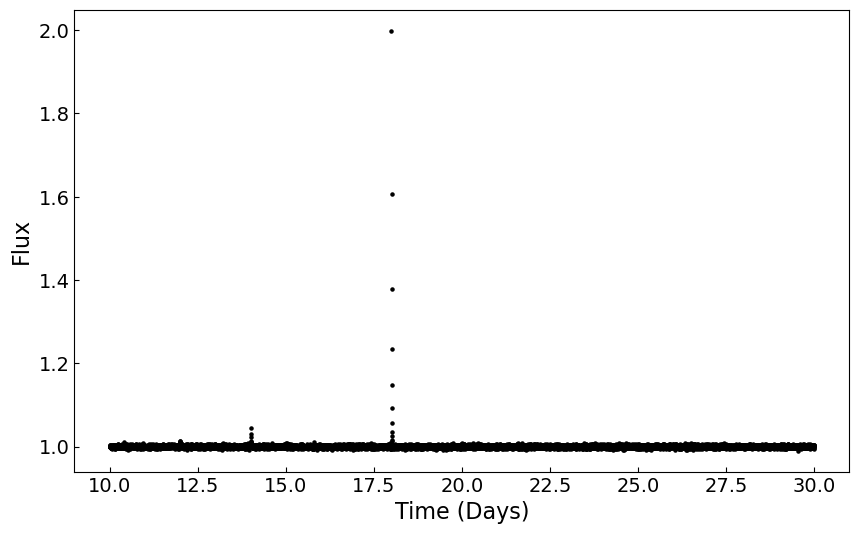

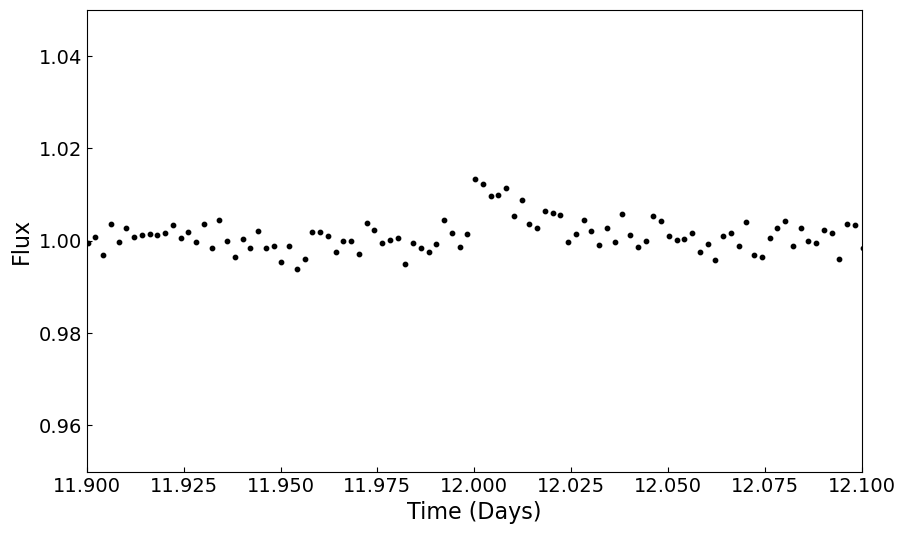

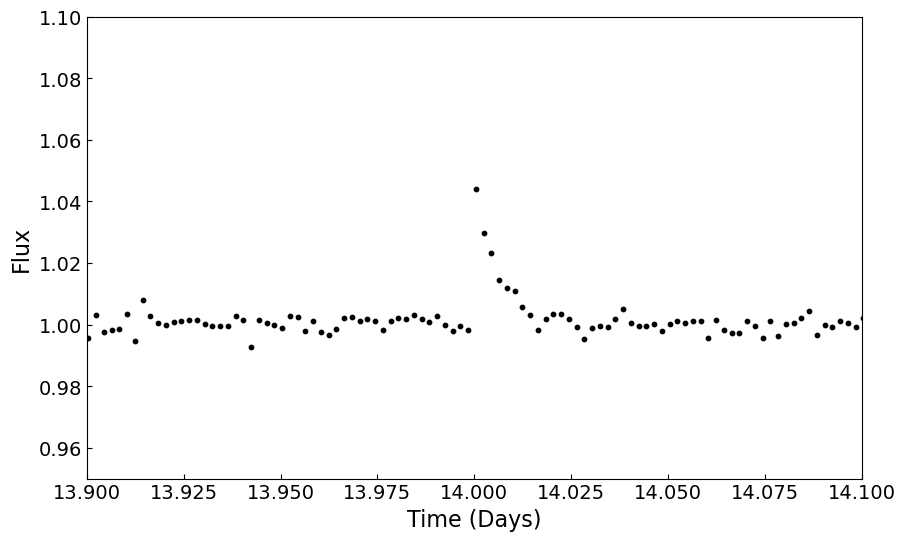

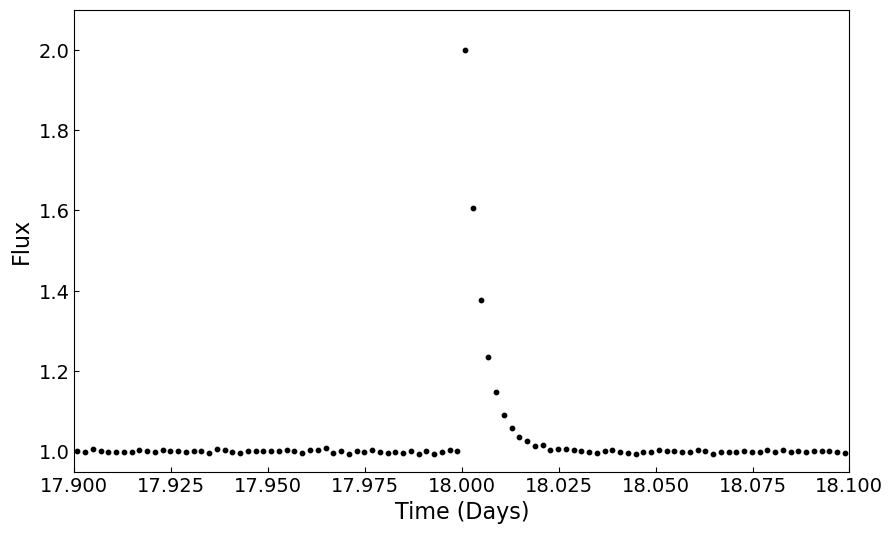

In [37]:
np.random.seed(42)
#Define the functions to set the shapes of samples flares
#rise
def guassian_rise(x, alpha, sigma, c):
    return alpha * np.exp(-(x - flare_peak_time)**2 / (2 * sigma)**2) + c

#decay
def dbl_exp_decay(x, start_time, alpha_0, beta_0, alpha_1, beta_1, C):
    return (alpha_0 * np.exp(- beta_0 * (x - start_time)) +
            alpha_1 * np.exp(- beta_1 * (x - start_time))  + C)

#Simple, detrended lightcurve
time = np.linspace(10, 30, 10000) #just some time labels for TOFFEE
flux = 1 + np.random.normal(0, 2.5*10**-3, 10000) #Note we set the spread of the points to 10**-2
flux_err = np.full(10000, 10**-2) #same as spread of points
quality = np.full(10000, 0) #state all qualities are good

#Add a small flare
flux[1000:1020] = dbl_exp_decay(time[1000:1020], time[1000], 0.0075, 50, 0.0075, 100, 1) + np.random.normal(0, 2.5*10**-3, 20)

#Add a medium flare
flux[2000:2050] = dbl_exp_decay(time[2000:2050], time[2000], 0.02, 150, 0.02, 200, 1) + np.random.normal(0, 2.5*10**-3, 50)

#Add a large flare
flux[4000:4100] = dbl_exp_decay(time[4000:4100], time[4000], 0.5, 200, 0.5, 300, 1) + np.random.normal(0, 2.5*10**-3, 100)

#plot
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 5)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.xlim(11.9, 12.1)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.xlim(13.9, 14.1)
plt.ylim(0.95, 1.1)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()


#plot each flare
plt.figure(figsize = (10,6))
plt.scatter(time, flux, color = 'black', s = 10)
plt.xlim(17.9, 18.1)
plt.ylim(0.95, 2.1)
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)
plt.show()

So we can see the massive spike around day 18, the smaller one around day 14, and the little nub at day 12. It's actually not that small, just in comparison to that massive flare.

Let's run through TOFFEE, see the outputs it gives us, and how it relates to whether or not it's accurately found our flares.

In [40]:
#Run through TOFFEE
#Turn off detrend because the curve is already detrended. Also the times are not aligned with any actual
#TESS orbits so it wouldn't work with our detrending code anyways.
flare_characteristics = toffee.flare_finder(time, flux, flux_err, quality, detrend  = False)

flare_characteristics

(array([12.00020002, 14.00040004, 18.00080008]),
 array([12.00020002, 14.00040004, 18.00080008]),
 array([12.02220222, 14.01240124, 18.02680268]),
 array([0.0133014 , 0.04385967, 0.99889308]),
 array([ 14.79009473,  19.87943766, 365.85110179]),
 array(['primary', 'primary', 'primary'], dtype='<U7'),
 array([11,  6, 13]),
 array([ 6,  6, 11]),
 array([  5.22562997,  17.23084772, 392.42827826]))

The output of flare_finder is a tuple containing information on the three flares found.

The first index, flare_characteristics[0], gives the times of the peaks of the flares. As far as correlating flare occurrence with time this is the gold standard. It's much more obvious a signifier of a flare and will be more consistent and less finicky as tracking down the beginnign or end of the flare.

The next index, flare_characteristics[1] & flare_characteristics[2], give the beginnings and ends of the flares. It's important for tracking how the energy of the flare is calculated from the equivalent duration. The fluxes of all the points between these two times are integrated to derive the equivalent duration.

The next index, flare_characteristics[3], gives the amplitude of the flare in terms of flux. A value of 0.0133 for the first flare corresponds to the peak flux of the flare being 1.0133. So the flare made the star 1.33% brighter for a few minutes.

The next index, flare_characteristics[4], gives the equivalent duration of the flares. The equivelent duration is a measure of energy for a flare defined as the amount of time (in seconds) that the star would normally need to shine to output the same energy as the flare. Multiplying the ED by the quiescent luminosity of the star will return the energy of the flare in usable units like erg/s

The next lists provide more of a qualitative description of the flares

flare_characteristics[5] gives the 'type' of flare of each flare. This feature is the central focus of TOFFEE, to distiguish between potentially overlapping flares in a lightcurve. Here it's told whether said overlapping flares have been found.

'primary': Means this is a flare that was found where the peak was identified,
it was modeled, and passed the checks. There may or may not have been a fit applied to the rise and decay. There may or may nor have been a secondary found to this flare.

'primary_dbl_fit_failed': A special type of primary flare in which a double exponential
was fit to the decay with no secondary found. However it seemed like there was possibly another flare that was just missed so it tried to refit the decay and still didn't find a secondary. We keep track of these to see the relative success of these attempted refittings to find more secodnary flares.

'secondary': Means this flare was found within a primary flare. It may be in the rise or the decay.
It was found on the first attempt of fitting a model to the rise and decay with no need for a refit

'secondary_second_try': A special type of secondary that was found in the decay of a flare only
after refitting the model without brighter points that affected the first fit

flare_characteristics[6] gives the total number of points associated with the flare

flare_characteristics[7] gives the total number of points associated with the flare above the threshold

As we'll see later, TOFFEE can count points below the flux threshold as being a part of a flare. This is built into the process to make sure a two bright epochs separated by only a couple cadences below the threshold is counted as one flare rather than two separate flares. So flare_characteristics[7] will generally be larger than flare_characteristics[6].

flare_characteristics[8] gives the amplitude of the flare in terms of the spread of the flux points, $\sigma$. It tells us how much the flare peaks out from the noise of the lightcurve. It's the form of amplitude I work with the most because TOFFEE doesn't really see flux it's measuring everything against the noise of the lightcurve to look for a signal. So this tells us how strong that signal was. It also has implications to tracking the completeness of your flares as we should expect incompleteness for amplitudes below $4\sigma$ if you're using the normal $3\sigma$ threshold. If not you'll get incompleteness at $(N+1)\sigma$ where $N$ is your given threshold. See Pratt et al. 2025 for more info.

We can transform this tuple to a pandas DataFrame

In [43]:
flare_frame = pd.DataFrame(np.array(flare_characteristics).T, columns = ['T_peak', 'T_start', 'T_end', 'Amplitude', 'ED',
                                                                'Primary_or_Secondary', 'Num_Points', 'Num_Abv_Threshold',
                                                                'Amp_Sigma'])

flare_frame

,T_peak,T_start,T_end,Amplitude,ED,Primary_or_Secondary,Num_Points,Num_Abv_Threshold,Amp_Sigma
0,12.000200020002,12.000200020002,12.022202220222022,0.013301400342197178,14.79009473256781,primary,11,6,5.225629970924988
1,14.000400040004,14.000400040004,14.012401240124014,0.04385966956822496,19.879437662490183,primary,6,6,17.230847723866322
2,18.000800080008,18.000800080008,18.026802680268027,0.9988930834792427,365.8511017889026,primary,13,11,392.42827826326226


## Plot Results

Here's a script I use to plot the lightcurves with the flares overlaid on them. Feel free to use it.

It only works on lightcurves that have already been detrended, like our synthetic example.

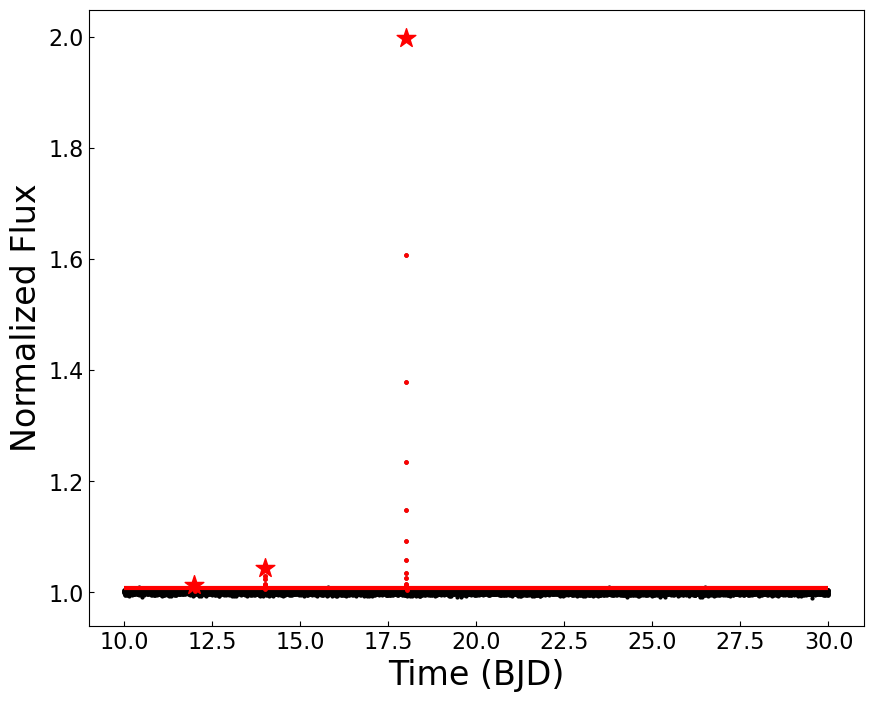

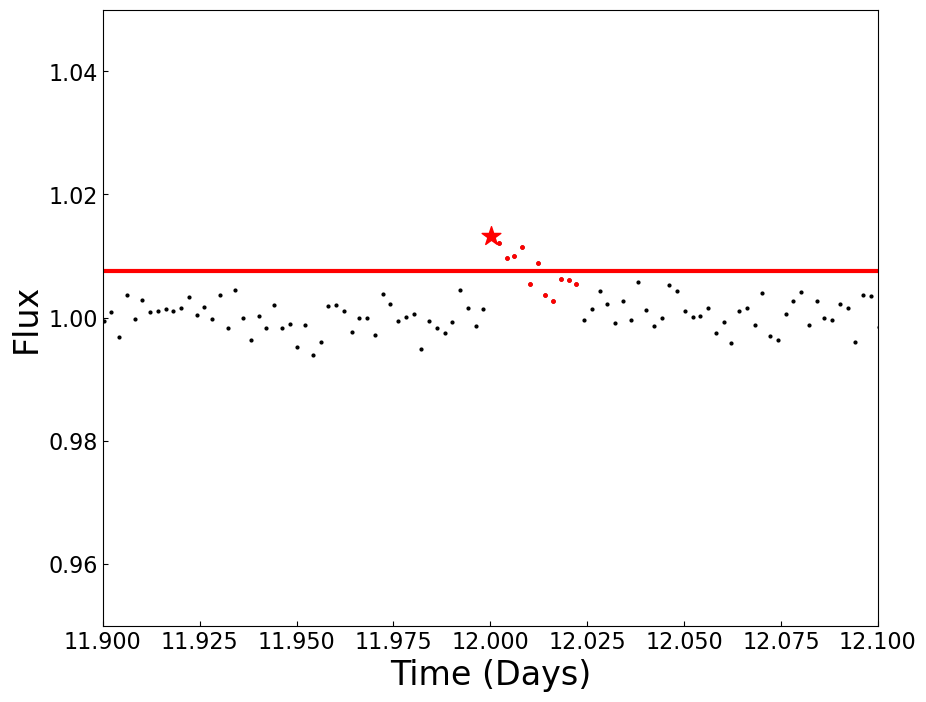

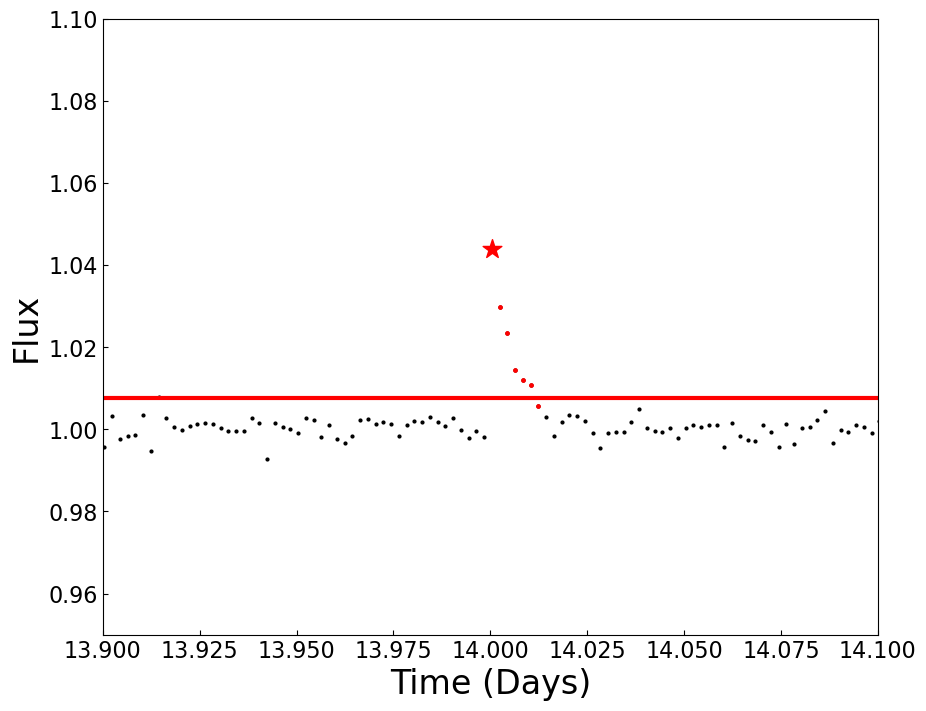

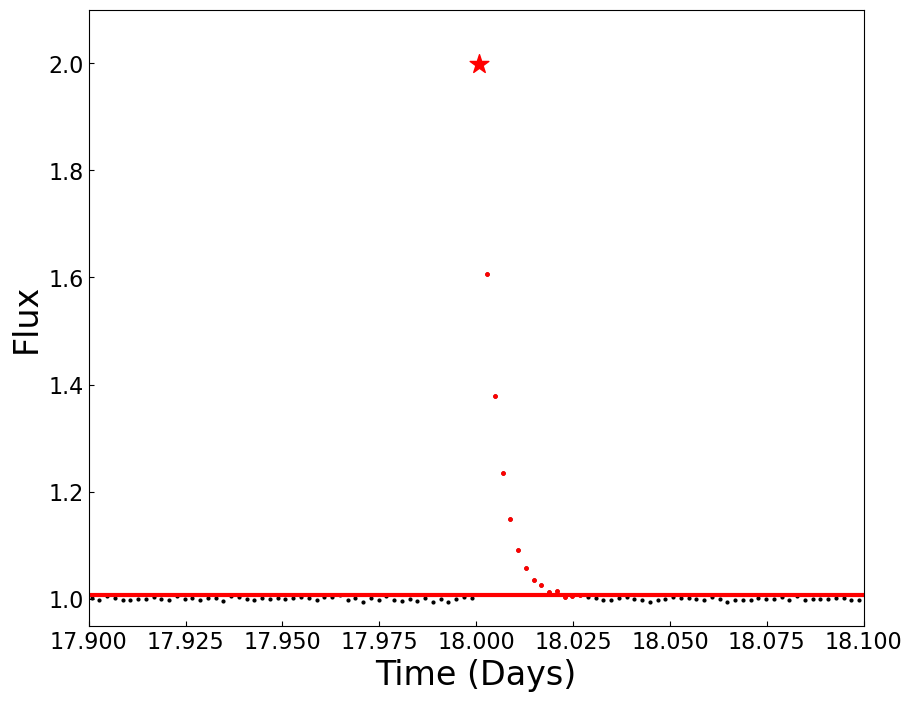

In [58]:
primary_color = 'red'

secondary_color = 'blue'

###############Now is when we need to find the flares to plot them#############

flare_results = toffee.flare_finder(time, flux, flux_err, quality, detrend = False)


flare_peak_times, flare_start_times, flare_end_times, flare_amps, flare_type, num_points_in_flare = (flare_results[0],
                                                                                                     flare_results[1],
                                                                                                     flare_results[2],
                                                                                                     flare_results[3],
                                                                                                     flare_results[5],
                                                                                                     flare_results[6])
###########Let's find the points belonging to the flares###########

#For primaries

#array holding the times of the flare points

times_of_primary_flares = np.array([])

#array holding associated fluxes

fluxes_of_primary_flares = np.array([])

#array holding peak times

peak_time_of_primary = np.array([])

#array holding peak flux

peak_flux_of_primary = np.array([])




#array holding the times of the flare points

times_of_secondary_flares = np.array([])

#array holding associated fluxes

fluxes_of_secondary_flares = np.array([])

#array holding peak times

peak_time_of_secondary = np.array([])

#array holding peak flux

peak_flux_of_secondary = np.array([])





#iterate through the flares and find the relevant times

for i in range(len(flare_start_times)):

    start = flare_start_times[i]

    end = flare_end_times[i]

    #find indices of flux points between these values

    flare_flux_points = np.where((time >= start) & (time <= end))[0]

    #and log those times in the flare

    flare_times = time[flare_flux_points]

    #and log those fluxes

    flare_fluxes = flux[flare_flux_points]


    #find the peak flux

    peak_flux = np.max(flare_fluxes)

    #and associated time

    peak_time = flare_times[np.argmax(flare_fluxes)]

    #sort depending on type

    if (flare_type[i] == 'primary') or (flare_type[i] == 'primary_failed_dbl_fit'):

        #add to the list
        times_of_primary_flares = np.append(times_of_primary_flares, flare_times)
    
        fluxes_of_primary_flares = np.append(fluxes_of_primary_flares, flare_fluxes)

        peak_flux_of_primary = np.append(peak_flux_of_primary, peak_flux)

        peak_time_of_primary = np.append(peak_time_of_primary, peak_time)


    else:

        #add to the list
        times_of_secondary_flares = np.append(times_of_secondary_flares, flare_times)
    
        fluxes_of_secondary_flares = np.append(fluxes_of_secondary_flares, flare_fluxes)

        peak_flux_of_secondary = np.append(peak_flux_of_secondary, peak_flux)

        peak_time_of_secondary = np.append(peak_time_of_secondary, peak_time)



#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlabel('Time (BJD)', fontsize = 24)
plt.ylabel(r'Normalized Flux', fontsize = 24)
#plt.ylim(0.9, 1.25)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()



#plot each flare
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlim(11.9, 12.1)
plt.ylim(0.95, 1.05)
plt.xlabel('Time (Days)', fontsize = 24)
plt.ylabel('Flux', fontsize = 24)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

#plot each flare
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlim(13.9, 14.1)
plt.ylim(0.95, 1.1)
plt.xlabel('Time (Days)', fontsize = 24)
plt.ylabel('Flux', fontsize = 24)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()


#plot each flare
plt.figure(figsize = (10,8))
plt.scatter(time, flux, s = 4, color = 'black')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flux, 84) - 1) + 1, min(time), max(time), color = 'red', linewidth = 3)
plt.xlim(17.9, 18.1)
plt.ylim(0.95, 2.1)
plt.xlabel('Time (Days)', fontsize = 24)
plt.ylabel('Flux', fontsize = 24)
plt.tick_params(direction = 'in', labelsize = 16)
plt.show()

### So that's the basics

So long as you already have your lightcurve and pluf in the time, flux, flux_err, and quality you can run TOFFEE. It spits out a host of outputs telling us about the various flares found in the lightcurve.

NOTE:

time, flux, flux_err, and quality MUST all be the same size and 1D

If you're making synthetic lightcurves and want to add modulation, the time coordinates MUST line up with actual TESS orbits. If I were to run the above lightcurve through detrending I would get an error because the code masks out all the times that don't correspond to an orbit so we'd end up with no points to run detection on.

# Practice with Real Examples

Now let's complicate things with real, messy data from a star with many flares.

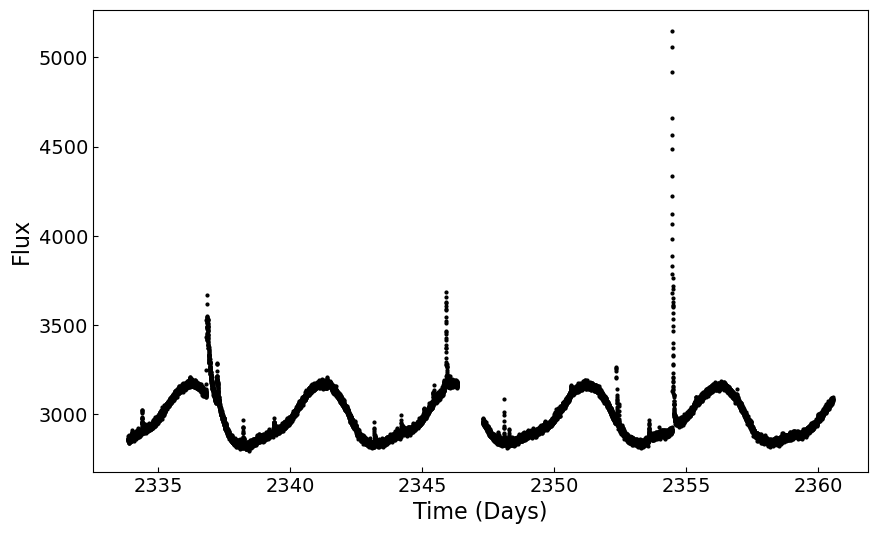

In [29]:
TIC_number = 452591471
TESS_sector = 38

TIC_number = 378126824
TESS_sector = 37

TIC_number = 359641042
TESS_sector = 38

lc = lk.search_lightcurve('TIC ' + str(TIC_number), sector = TESS_sector, mission = 'TESS', author = 'SPOC', exptime = 120).download()

time = lc.time.value
#unmask flux, quality, and flux error
flux = np.array(lc.flux.value)
quality = np.array(lc.quality.value)
flux_err = np.array(lc.flux_err.value)

#time = time[np.isnan(flux) == False]
#flux_err = flux_err[np.isnan(flux) == False]
#quality = quality[np.isnan(flux) == False]
#flux = flux[np.isnan(flux) == False]

plt.figure(figsize = (10,6))
plt.scatter(time, flux, s = 4, color = 'black')
plt.xlabel('Time (Days)', fontsize = 16)
plt.ylabel('Flux', fontsize = 16)
plt.tick_params(direction = 'in', labelsize = 14)

# Run Through TOFFEE

Now here's a more general script to plot flares on the lightcurve. Feel free to use this

/opt/anaconda3/lib/python3.12/site-packages/toffee/main.py:1136: RuntimeWarning: divide by zero encountered in scalar divide
  bright_ratio = len(num_past_threshold)/bright_range


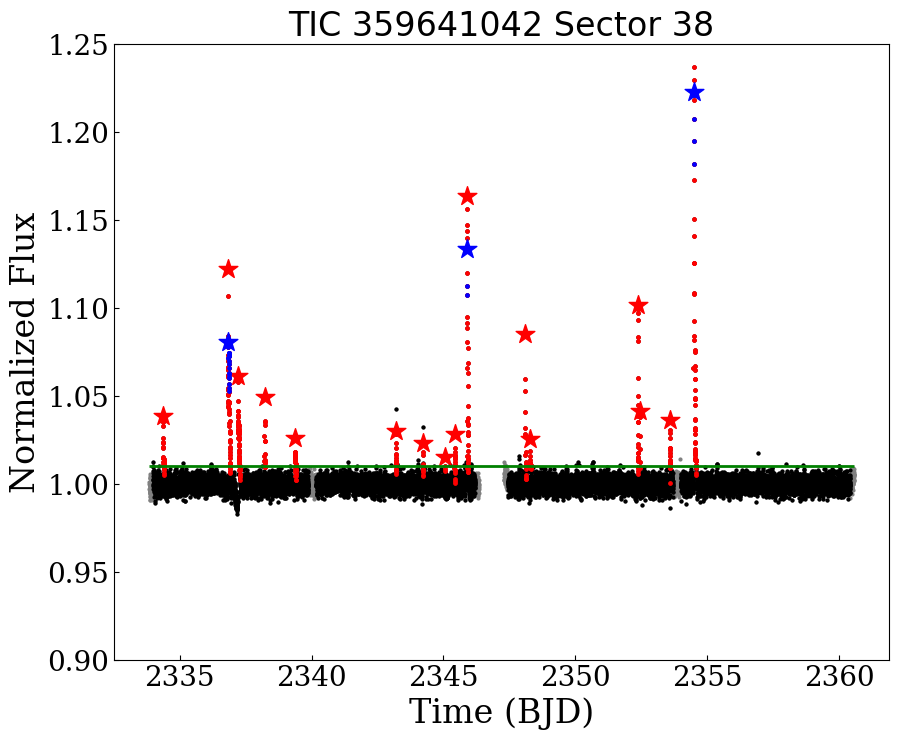

In [32]:
#Detrend

t_curve, quadratic, wotan_fit, flatt, periodic = toffee.flatten(time, flux, flux_err, plot_results=False,
                                              short_window=0.25, periodogram=[0.01, 10])

#sometimes the size of the arrays spat out by the flattening function is not the same as the light
#curve and thus not the same as the break_mask. So we need another mask to ensure they're the same

flattening_mask = np.full(len(time), 1, dtype = bool)

for index in range(len(time)):
    if time[index] in t_curve:
        continue
    else:
        flattening_mask[index] = False

#convert this mask to indices to include in the mask
flattening_mask = np.arange(len(time))[flattening_mask]

#find the breaks
sector_break_frame = toffee.break_finder(time, flux)
#Now color in the masked points in a different color
mask = toffee.light_curve_mask(time, flux, min_break = 0.01, clip_breaks = 100)
#apply flattening mask
mask = mask[flattening_mask]
#unpack flux after running periodogram and eliminating residual
#sinusoidal noise
flatt_trend = flatt[2]
flatt_flux = flatt[0]


###############Now is when we need to find the flares to plot them#############
flare_results = toffee.flare_finder(time, flux, flux_err, quality, visualize_fit = False, rise_func = 'gaussian', consecutive = False,
                             periodogram = [0.01, 10], clip_breaks = 100,
                             min_break = 0.025, fit_twice = True, fit_multiple_secs = False)

#pull out relevant features

flare_peak_times, flare_start_times, flare_end_times, flare_amps, flare_type, num_points_in_flare = (flare_results[0],
                                                                                                     flare_results[1],
                                                                                                     flare_results[2],
                                                                                                     flare_results[3],
                                                                                                     flare_results[5],
                                                                                                     flare_results[6])

###########Let's find the points belonging to the flares###########

#For primaries

#array holding the times of the flare points

times_of_primary_flares = np.array([])

#array holding associated fluxes

fluxes_of_primary_flares = np.array([])

#array holding peak times

peak_time_of_primary = np.array([])

#array holding peak flux

peak_flux_of_primary = np.array([])




#array holding the times of the flare points

times_of_secondary_flares = np.array([])

#array holding associated fluxes

fluxes_of_secondary_flares = np.array([])

#array holding peak times

peak_time_of_secondary = np.array([])

#array holding peak flux

peak_flux_of_secondary = np.array([])





#iterate through the flares and find the relevant times

for i in range(len(flare_start_times)):

    start = flare_start_times[i]

    end = flare_end_times[i]

    #find indices of flux points between these values

    flare_flux_points = np.where((t_curve >= start) & (t_curve <= end))[0]

    #and log those times in the flare

    flare_times = t_curve[flare_flux_points]

    #and log those fluxes

    flare_fluxes = flatt_flux[flare_flux_points]


    #find the peak flux

    peak_flux = np.max(flare_fluxes)

    #and associated time

    peak_time = flare_times[np.argmax(flare_fluxes)]

    #sort depending on type

    if (flare_type[i] == 'primary') or (flare_type[i] == 'primary_failed_dbl_fit'):

        #add to the list
        times_of_primary_flares = np.append(times_of_primary_flares, flare_times)
    
        fluxes_of_primary_flares = np.append(fluxes_of_primary_flares, flare_fluxes)

        peak_flux_of_primary = np.append(peak_flux_of_primary, peak_flux)

        peak_time_of_primary = np.append(peak_time_of_primary, peak_time)


    else:

        #add to the list
        times_of_secondary_flares = np.append(times_of_secondary_flares, flare_times)
    
        fluxes_of_secondary_flares = np.append(fluxes_of_secondary_flares, flare_fluxes)

        peak_flux_of_secondary = np.append(peak_flux_of_secondary, peak_flux)

        peak_time_of_secondary = np.append(peak_time_of_secondary, peak_time)



#Third plot: Show the flattened lightcurve with the flares found and colored in
plt.figure(figsize = (10,8))
plt.scatter(t_curve, flatt_flux, s = 4, color = 'gray')
#plot all the good flux points not masked 
plt.scatter(t_curve[mask], flatt_flux[mask], s = 4, color = 'black', label = 'Used')
#the plot for the residual periodogram result
#plt.plot(time, flatt_trend, color = 'yellow')
#color the points around the primary flares
plt.scatter(times_of_primary_flares, fluxes_of_primary_flares, color = primary_color, s = 6)
#color the points around the secondary flares
plt.scatter(times_of_secondary_flares, fluxes_of_secondary_flares, color = secondary_color, s = 6, zorder = 10)
#add primary flare peaks
plt.scatter(peak_time_of_primary, peak_flux_of_primary, marker = '*', s = 200, color = primary_color)       
#add secondary flare peaks
plt.scatter(peak_time_of_secondary, peak_flux_of_secondary, marker = '*', s = 200, color = secondary_color)
#add three sigma line
plt.hlines(3 * (np.nanpercentile(flatt_flux, 84) - 1) + 1, min(time), max(time), color = 'green', linewidth = 2)
plt.xlabel('Time (BJD)', fontsize = 24, font = 'Serif')
plt.ylabel(r'Normalized Flux', fontsize = 24, font = 'Serif')
plt.ylim(0.9, 1.25)
plt.tick_params(direction = 'in', labelsize = 20, labelfontfamily = 'Serif')
plt.title('TIC ' + str(TIC_number) + ' Sector ' + str(TESS_sector), fontsize = 24)
plt.show()

We'll see more about the distinctions between the red and blue points in subsequent tutorials. But as to not bury the lead the red stars are primary flares and the blue stars are secondary flares.